# Regresión lineal IX. Introducción a la regresión lineal

In [35]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#  Modelado y evaluación
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#  Crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).



In [36]:
df = pd.read_csv("data/sephora_encoding.csv", index_col = 0)
df.head(1)

,brand,category,size,rating,number_of_reviews,love,price,online_only,exclusive,limited_edition,...,size_encoding,category_map,brand_encoding,online_only_No,online_only_Yes,exclusive_No,exclusive_Yes,limited_edition_No,limited_edition_Yes,rating_map
0,Acqua Di Parma,Fragrance,5 x 0.16oz/5mL,4.0,-0.215962,0.156305,66.0,Yes,No,No,...,59,0,63,0,1,1,0,1,0,1


El objetivo de este pairprogramming es que hagáis vuestro primer modelo de machine learning. Para eso recordad que:

1. Deberéis separar la X y la y: 

In [37]:
# Separamos la variable respuesta de las variables predictoras.

X = df.drop(["price", "price_box", "size", "brand", "category", "rating", "love", "online_only", "exclusive", "limited_edition"], axis = 1) 

# Nos quedamos con la variable respuesta normalizada. 

y = df["price_box"] 

2. Deberéis crear el train y el test:


In [38]:
# Separamos el train y el test.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

3. Ajustar vuestro modelo.

In [39]:
lr = LinearRegression(n_jobs = -1)

In [40]:
lr.fit(x_train, y_train)

LinearRegression(n_jobs=-1)

In [41]:
# Realizamos las predicciones.

y_predict_train = lr.predict(x_train)                         

y_predict_test = lr.predict(x_test)

In [42]:
# Creamos los DataFrames con los resultados.

train_df = pd.DataFrame({"real": y_train, "predicted": y_predict_train, "set": ["train"]*len(y_train)})
test_df  = pd.DataFrame({"real": y_test,  "predicted": y_predict_test,  "set": ["test"]*len(y_test)})

resultados = pd.concat([train_df,test_df], axis = 0)

In [43]:
# Creamos una columna nueva con la diferencia entre los valores predichos y los reales.

resultados["residuos"] = resultados["real"] - resultados["predicted"]
resultados.head()

,real,predicted,set,residuos
215,10.080523,11.100239,train,-1.019717
294,10.930990,9.001012,train,1.929977
49,8.940999,9.263875,train,-0.322876
720,8.749507,7.070933,train,1.678574
235,9.806965,9.470312,train,0.336653


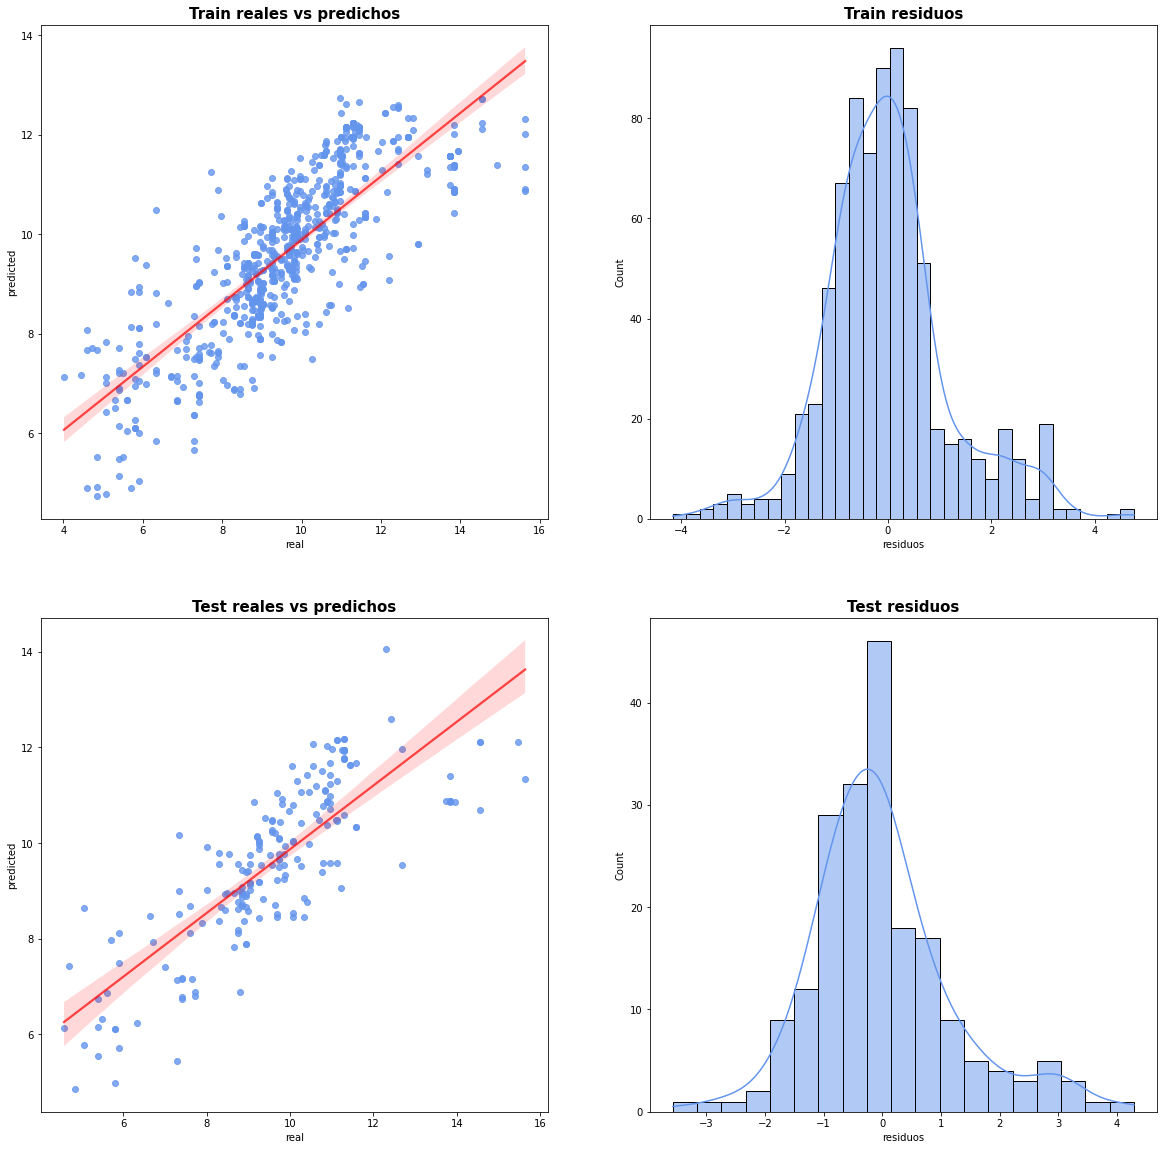

In [44]:
# Lo comprobamos visualmente.

fig, ax = plt.subplots(2,2,figsize=(20,20))

sns.regplot(data = resultados[resultados["set"] == "train"], 
            x = "real", 
            y = "predicted", 
            ax = ax[0,0], 
            color = "cornflowerblue",
            line_kws = {"color": "red", "alpha": 0.7 })

sns.regplot(data = resultados[resultados["set"] == "test"], 
            x = "real",
            y = "predicted", 
            color = "cornflowerblue",
            line_kws = {"color": "red", "alpha": 0.7 }, 
            ax = ax[1,0])

sns.histplot(resultados[resultados["set"] == "train"],
             x= "residuos",
             color = "cornflowerblue",
             kde = True, 
             ax = ax[0,1])

sns.histplot(resultados[resultados["set"] == "test"],
             x = "residuos",
             color = "cornflowerblue",
             kde = True, 
             ax = ax[1,1])

ax[0,0].set_title("Train reales vs predichos", fontsize = 15, fontweight = "bold")
ax[0,1].set_title("Train residuos", fontsize = 15, fontweight = "bold")
ax[1,0].set_title("Test reales vs predichos", fontsize = 15, fontweight = "bold")
ax[1,1].set_title("Test residuos", fontsize = 15, fontweight = "bold");

Podemos ver que nuestro modelo se ajusta relativamente bien a la línea, por lo que parece que hace buenas predicciones. Además, la mayor parte de los residuos están también cercanos a cero, lo que es un buen indicador. No obstante, hay que tener en cuenta que nuestros datos no están normalizados, por lo que este tipo de algoritmo no nos sirve. 

In [45]:
# Permite testar una única métrica.

cv_scores = cross_val_score(
                estimator = LinearRegression(), 
                X         = X, 
                y         = y,
                scoring   = "neg_root_mean_squared_error",
                cv        = 10
             )

print(f"Métricas validación cruzada: {cv_scores}") 
print(f"Média métricas de validación cruzada: {cv_scores.mean()}") 

Métricas validación cruzada: [-1.33527713 -0.8948208  -1.02721128 -1.02410218 -1.14735828 -1.30111848
 -1.00284137 -0.97522028 -2.169181   -1.18473934]
Média métricas de validación cruzada: -1.2061870148130707


In [46]:
# Permite testar diferentes métricas.

cv_scores = cross_validate(
                estimator = LinearRegression(),
                X         = X,
                y         = y,
                scoring   = ("r2", "neg_root_mean_squared_error"),
                cv        = 10)

cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,test_neg_root_mean_squared_error
0,0.036853,0.006033,0.539426,-1.335277
1,0.012884,0.006418,0.581522,-0.894821
2,0.011006,0.011475,0.565687,-1.027211
3,0.018852,0.021638,0.544430,-1.024102
4,0.004395,0.004052,0.454925,-1.147358
5,0.003780,0.006309,0.581100,-1.301118
6,0.005833,0.003096,0.673655,-1.002841
7,0.007279,0.003315,0.619983,-0.975220
8,0.003920,0.002539,0.522647,-2.169181
9,0.009092,0.005287,0.614986,-1.184739


In [47]:
print(f'La media para el test_r2 es {cv_scores["test_r2"].mean()}')
print(f'La media para el RMSE es {abs(cv_scores["test_neg_root_mean_squared_error"].mean())}')

La media para el test_r2 es 0.5698362195685617
La media para el RMSE es 1.206187014813071


La función `cross_validate()` se puede utilizar para evaluar el rendimiento de un modelo de aprendizaje automático.

fit_time y score_time muestran el tiempo que tardó en ajustarse el modelo y en evaluar el modelo en el conjunto de prueba, respectivamente. En nuestro caso, estos tiempos son muy pequeños.

El coeficiente de determinación R2 es una medida de cómo de bien se ajusta el modelo a los datos. Una puntuación perfecta sería 1, y una puntuación de 0 significaría que el modelo no se ajusta a los datos en absoluto. El RMSE es una medida de lo cerca que están las predicciones del modelo a los valores reales. Un RMSE más bajo indica un mejor ajuste.

test_r2 va de 0,14 a 0,49, y las puntuaciones RMSE van de 1,15 a 2,22. Esto indica que el modelo no es un ajuste perfecto para los datos.

# Regresión lineal X. Métricas

En el pair programming anterior creastéis vuestro primer modelo de machine learning usando la regresion Lineal. Es el momento, que con vuestros datos evaluéis si es bueno haciendo predicciones. Los objetivo de este pairprogramming son:

1. Calculéis las métricas para vuestro modelo


In [48]:
# Obtenemos las métricas de nuestro modelo.

resultados_metricas = {'MAE': [mean_absolute_error(y_test, y_predict_test), mean_absolute_error(y_train, y_predict_train)],
                'MSE': [mean_squared_error(y_test, y_predict_test), mean_squared_error(y_train, y_predict_train)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_predict_test)), np.sqrt(mean_squared_error(y_train, y_predict_train))],
                'R2':  [r2_score(y_test, y_predict_test), r2_score(y_train, y_predict_train)],
                "set": ["test", "train"], 
                "modelo": ["Linear Regresion", "Linear Regresion"]}

df_resultados = pd.DataFrame(resultados_metricas)

df_resultados

,MAE,MSE,RMSE,R2,set,modelo
0,0.874496,1.461844,1.209067,0.658808,test,Linear Regresion
1,0.878977,1.451425,1.204751,0.637304,train,Linear Regresion


2. Discutid los resultados de las métricas y extraed conclusiones


- R2: tenemos un porcentaje de entre 0.65 y 0.67, por lo que no son métricas muy buenas. 
- MAE: no sobrepasan el 1, tenemos 0.87.
- MSE: no sobrepasan el 1.5.
- RMSE: llegan al 1.2.

Por tanto, nuestras métricas son aceptables, pero mejorables. El MAE, MSE y RMSE deberían estar más cercanas a 0, mientras que R2 debería estar más cerca del 1 para ser considerado un buen modelo.

In [49]:
# Invertimos el box_cox para ver cuánto se diferencia nuestro modelo de los datos.

df["price_box2"], lambda_ajustada = stats.boxcox(df["price"])

In [50]:
inv_boxcox(df_resultados["RMSE"], lambda_ajustada)

0    2.808021
1    2.799122
Name: RMSE, dtype: float64

#### Conclusión final
Como no tenemos datos normalizados y como no cumple las tres asunciones necesarias para realizar el algoritmo de regresión lineal, podemos comprobar que no nos han salido muy buenos resultados en el modelo. Al tratar de predecir el precio, nuestro modelo se equivoca entre 2.79$ y 2.80$, lo cual es relativamente un rango muy bajo, teniendo en cuenta que nuestro mayor precio es 335$, mientras que nuestro precio mínimo es 14$. Además, nuestros resultados son peores en el train que en el test, aunque muy parecidos, lo cual nos indica que **no** estamos en un caso de *overfitting*.

Podemos concluir, por tanto, que nuestro modelo no es un éxito.

3. Guardad los resultados de las métricas en un csv para usarlo más adelante.

In [52]:
df_resultados.to_csv("data/resultados_metricas.csv")